## 1. Load Data
 - Load data from database and save as csv file
 - Originally I made machine learning to use data from database directly
 - By the resource from https://www.lucypark.kr/slides/2015-pyconkr/#39, comments over 7 points are loaded.
 - To reduce time consume for a test, I used the file the data saved

In [26]:
import nltk
import numpy as np
import pandas as pd
import many_stop_words as msw
import matplotlib.pyplot as plt

from matplotlib import font_manager, rc
from konlpy.tag import Twitter
from konlpy.utils import pprint
from gensim.models import doc2vec
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cross_validation import cross_val_score


In [2]:
df = pd.read_csv('./dataset/train_jup.csv')
len(df)

310653

In [3]:
df = df.dropna()

In [4]:
len(df)

310647

- Dataset has only 6 NaN, so it is almost impossible that result could be changed by 6 rows held NaN

In [5]:
# How they look at
df.tail()

,genre,comment
310648,6,말이 필요없는 명작 영화끝나고 남는 쥬다벤허
310649,6,벤허초등학교때뭔지모르고 봤던영화~~2016년 지금은 보고또보고또보고^^진짜대박멋진...
310650,13,마지막 엄마가 한짓은 좀 억지스러운 설정인듯..그냥 그대로 끝났더라면 더 자연스러웠...
310651,13,끝나기 3분전까지 눈물 흘리다 마지막에 소름
310652,6,말이필요없는 그냥 무조건한번쯤은 봐야할영화.


### 15 Categories
Tag|Eng|Kor
---|---|---
1 | Drama | 드라마
2 | Fantasy | 판타지
3 | Western | 서부
4 | Horror | 공포
5 | Melo/Love/Romance | 멜로/애정/로맨스
6 | Adventure | 모험
7 | Thriller | 스릴러
8 | Noir | 느와르
10| Documentary | 다큐멘터리
11| Comedy | 코미디
12| Family | 가족
13| Mystery | 미스터리
14| War | 전쟁
15| Animation | 애니메이션
16| Crime | 범죄

In [6]:
# comments for each tag(=genre)
a = list(set(df.genre))
count = []
for num in a:
    print 'tag: ' + str(num), len(df[df.genre==num])
    count.append(len(df[df.genre==num]))

tag: 1 106811
tag: 2 12381
tag: 3 973
tag: 4 16739
tag: 5 33538
tag: 6 12254
tag: 7 11695
tag: 8 825
tag: 10 5401
tag: 11 52429
tag: 12 5137
tag: 13 6672
tag: 14 5204
tag: 15 34353
tag: 16 6235


#### As you see below the graph, comments are not distributed equally
- This fact could be negative to predict tag using comments

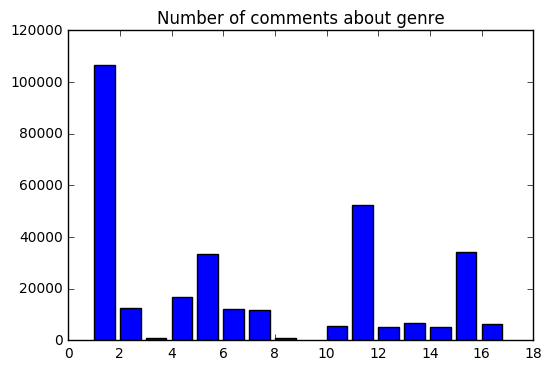

In [7]:
plt.bar(a, count)
plt.title('Number of comments about genre')
plt.show()

# 2. Sentiment Analysis

- comment is decomposed by Konlpy.tag, especially Twitter
- Becuase comment term is similar with twit term, twitter.pos is used

 - For Text analysis, sentence has to decomposed to smallest unit.
 - If not, whole sentence would be just 'one' data, and impossible to calculate similarity and so on.

In [8]:
twitter = Twitter()

# the function helps to decompose a comment to smallest unit and tagging
def tokenize_pos(doc):
    return [ '/'.join(tag) for tag in twitter.pos(doc)]

In [9]:
# My laptop can't handle whole data, so I use 20000 datas in 310,647
y = df['genre'][:20000]
X = df['comment'][:20000]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [11]:
test_docs = [(tokenize_pos(row_x.decode('utf-8')), row_y) for row_x, row_y in zip(X_test, y_test)]
train_docs = [(tokenize_pos(row_x.decode('utf-8')), row_y) for row_x, row_y in zip(X_train, y_train)]

In [12]:
# When comment is decomposed and tagged
pprint(train_docs[1])

([마지막/Noun,
  장면/Noun,
  은/Josa,
  정말/Noun,
  남자라면/Noun,
  눈물/Noun,
  이/Josa,
  안/VerbPrefix,
  나올/Verb,
  수/PreEomi,
  없다/Adjective],
 1)


 - How are words distributed? Equally?

In [13]:
tokens = [tag for data in train_docs for tag in data[0]]
print 'How many tokens do they have? ' + str(len(tokens))

How many tokens do they have? 262191


In [14]:
text = nltk.Text(tokens)
print 'Unique tokens :' + str(len(set(text.tokens)))

Unique tokens :17897


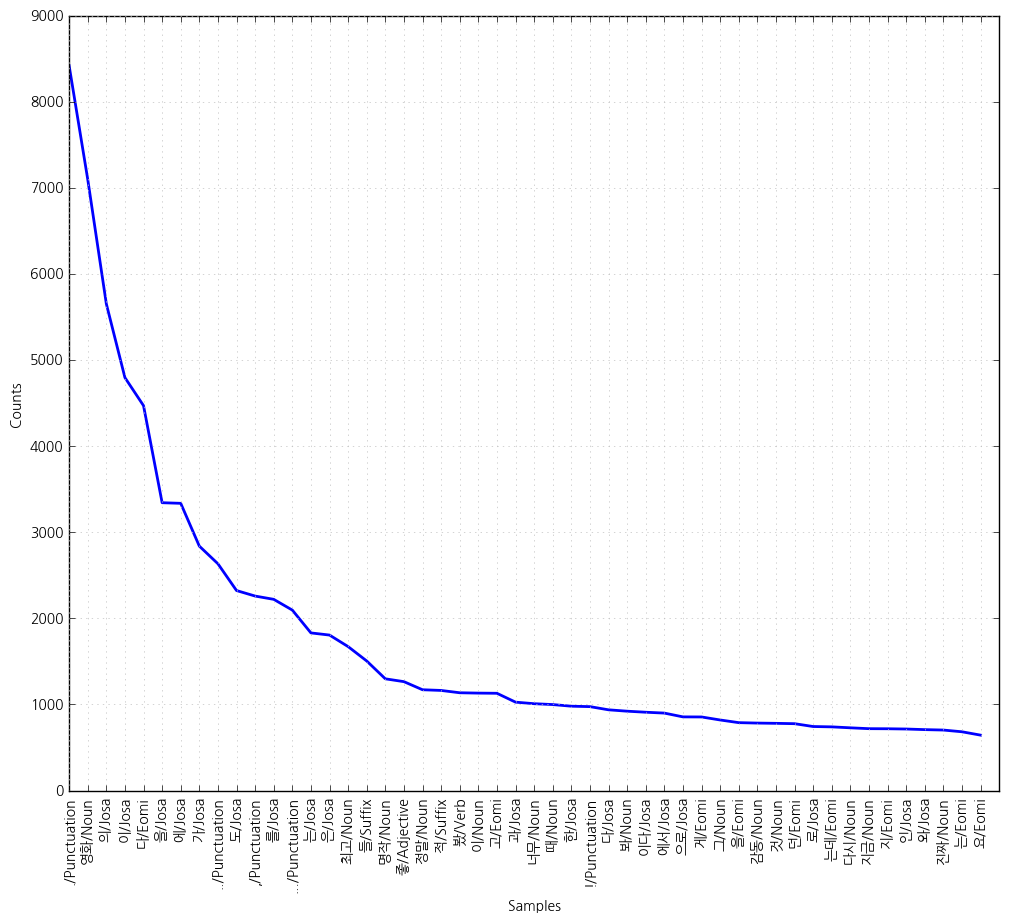

In [15]:
font_fname = 'c:/windows/fonts/NanumGothic.TTF' # font_fname should be changed as your compuser's OS
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)
plt.figure(figsize=(12,10))
text.plot(50) # show most_common till 50 rank
plt.show()

- As the graph showed, comment has some common words although tags are different

### I. Doc2Vec
- To use Doc2Vec, dataset should be changed to the doc2vec's template
- 'Tagged', 'word tag'
- If you call from gensim.models.doc2vec import TaggedDocument, TaggedDocument solves the problem

In [16]:
TaggedDocument = doc2vec.TaggedDocument
tagged_train_docs = [TaggedDocument(d, [c]) for d, c in train_docs]
tagged_test_docs = [TaggedDocument(d, [c]) for d, c in test_docs]

- Training using Doc2Vec

In [17]:
doc_vectorizer = doc2vec.Doc2Vec(size=300, alpha=0.025, min_alpha=0.025, seed=1234) # you can change the parameter
doc_vectorizer.build_vocab(tagged_train_docs) # build corpus

for epoch in range(10):
    doc_vectorizer.train(tagged_train_docs)
    doc_vectorizer.alpha -= 0.002
    doc_vectorizer.min_alpha = doc_vectorizer.alpha

In [18]:
train_x = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_train_docs]
train_y = [doc.tags[0] for doc in tagged_train_docs]
print len(train_x)
print len(train_x[0])

test_x = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_test_docs]
test_y = [doc.tags[0] for doc in tagged_test_docs]
print len(test_x)
print len(test_x[0])

15000
300
5000
300


In [19]:
result = {}

In [20]:
classifier = LogisticRegression(random_state=1234)
classifier.fit(train_x, train_y)
result['doc2vec_LR'] = classifier.score(test_x, test_y)

In [21]:
classifier = SVC(kernel='linear')
classifier.fit(train_x, train_y)
result['doc2vec_kSVC'] = classifier.score(test_x, test_y)

## II. Vectorizer
 - CountVectorizer: count the word
 - TfidfVectorizer: count the word + weight
 - In this case, common words should be not effect to categorize.
 - Assume TfidfVectorizer is fit

In [22]:
stopwords = msw.get_stop_words('kr')

In [23]:
model = Pipeline([('vect', CountVectorizer(tokenizer=tokenize_pos, stop_words=stopwords))])
features = model.fit_transform(X_train)
a = cross_val_score(SVC(kernel='linear'), features, y_train)
result['Count_kSVC'] = np.mean(a)

model = Pipeline([('vect', TfidfVectorizer(tokenizer=tokenize_pos, stop_words=stopwords))])
features = model.fit_transform(X_train)
b = cross_val_score(SVC(kernel='linear'), features, y_train)
result['Tfidf_kSVC'] = np.mean(b)

In [27]:
model = Pipeline([('vect', CountVectorizer(tokenizer=tokenize_pos, stop_words=stopwords))])
features = model.fit_transform(X_train)
a = cross_val_score(MultinomialNB(), features, y_train)
result['Count_MNB'] = np.mean(a)
# 0.42763895,  0.43579541,  0.43107711
model = Pipeline([('vect', TfidfVectorizer(tokenizer=tokenize_pos, stop_words=stopwords))])
features = model.fit_transform(X_train)
b = cross_val_score(MultinomialNB(), features, y_train)
result['Tfidf_MNB'] = np.mean(b)
# 0.37557452,  0.37587885,  0.37494205])

In [28]:
model = Pipeline([('vect', CountVectorizer(tokenizer=tokenize_pos, stop_words=stopwords))])
features = model.fit_transform(X_train)
a = cross_val_score(LogisticRegression(), features, y_train)
result['Count_LR'] = np.mean(a)
# 0.45058128,  0.45372016,  0.45170762])
model = Pipeline([('vect', TfidfVectorizer(tokenizer=tokenize_pos, stop_words=stopwords))])
features = model.fit_transform(X_train)
b = cross_val_score(LogisticRegression(), features, y_train)
result['Tfidf_LR'] = np.mean(b)

In [31]:
model = Pipeline([('vect', CountVectorizer(tokenizer=tokenize_pos, stop_words=stopwords))])
features = model.fit_transform(X_train)
a = cross_val_score(OneVsOneClassifier(LogisticRegression()), features, y_train)
result['Count_OvO'] = np.mean(a)
# 0.44216137,  0.44135826,  0.44011745])
model = Pipeline([('vect', TfidfVectorizer(tokenizer=tokenize_pos, stop_words=stopwords))])
features = model.fit_transform(X_train)
cross_val_score(OneVsOneClassifier(LogisticRegression()), features, y_train)
result['Tfidf_OvO'] = np.mean(b)

In [32]:
model = Pipeline([('vect', CountVectorizer(tokenizer=tokenize_pos, stop_words=stopwords))])
features = model.fit_transform(X_train)
a = cross_val_score(DecisionTreeClassifier(max_depth=16), features, y_train)
result['Count_DT'] = np.mean(a)
# 0.37959136,  0.38124855,  0.37923041])
model = Pipeline([('vect', TfidfVectorizer(tokenizer=tokenize_pos, stop_words=stopwords))])
features = model.fit_transform(X_train)
b = cross_val_score(DecisionTreeClassifier(max_depth=16), features, y_train)
result['Tfidf_DT'] = np.mean(b)

In [33]:
print result

{'Count_MNB': 0.48533632320298986, 'Count_DT': 0.47699918486585152, 'doc2vec_LR': 0.4304, 'Count_OvO': 0.53046788620121954, 'Tfidf_kSVC': 0.545200764000764, 'Count_LR': 0.55006703346703345, 'Tfidf_MNB': 0.42160048086714758, 'Tfidf_DT': 0.47606645133311803, 'Tfidf_OvO': 0.50246746940080278, 'Count_kSVC': 0.49693306406639737, 'doc2vec_kSVC': 0.41239999999999999, 'Tfidf_LR': 0.50246746940080278}


- Tfidf_kSVC is the best

In [ ]:
model = Pipeline([('vect', TfidfVectorizer(tokenizer=tokenize_pos, stop_words=stopwords)),
                  ('svc', SVC(kernel='linear', probability=True))])
model.fit(X_train, y_train)
print classification_report(y_test, model.predict(X_test))

In [34]:
model = Pipeline([('vect', TfidfVectorizer(tokenizer=tokenize_pos, stop_words=stopwords)),
                  ('svc', LogisticRegression())])
model.fit(X_train, y_train)
print classification_report(y_test, model.predict(X_test))

             precision    recall  f1-score   support

          1       0.48      0.97      0.64      2058
          2       0.86      0.27      0.41       276
          3       0.95      0.18      0.30       223
          4       0.80      0.32      0.45       250
          5       0.66      0.10      0.17       406
          6       0.76      0.26      0.38       340
          7       1.00      0.02      0.04        49
         11       0.60      0.22      0.32       546
         12       0.00      0.00      0.00        41
         13       0.00      0.00      0.00        30
         14       0.72      0.13      0.22       100
         15       0.87      0.31      0.45       325
         16       0.83      0.25      0.38       356

avg / total       0.64      0.53      0.46      5000



c:\python27\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Conclusion
- Comments in each genres have a little characteristics
- As data size, cross validation score is changed.
- CountVectorize_Logistic Regression looked the best but, in classification score, Tfidf_kSVC looked better 
- If I used whole data, could result be changed?